# Multiclass Text Classification with 
# Feed-forward Neural Networks and Word Embeddings

First, we will do some initialization.

In [15]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [16]:
# Cargamos el conjunto de entrenamiento desde el archivo CSV
train_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')

# Asignamos nombres de columna al DataFrame
train_df.columns = ['class index', 'title', 'description']

# Mostramos el DataFrame cargado
train_df

,class index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [17]:
# Cargamos las etiquetas de clase desde un archivo de texto y las almacenamos en una lista
labels = open('/kaggle/input/classes/classes.txt').read().splitlines()

# Mapeamos cada índice de clase en 'train_df' a su correspondiente etiqueta y creamos una columna 'class'
classes = train_df['class index'].map(lambda i: labels[i-1])
train_df.insert(1, 'class', classes)

# Seleccionamos aleatoriamente el 80% de los datos para entrenamiento
train_df = train_df.sample(frac=0.8, random_state=42)

# Mostramos el DataFrame actualizado
train_df

,class index,class,title,description
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...
...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel..."
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...


Let's inspect how balanced our examples are by using a bar plot.

/tmp/ipykernel_30/1245903889.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['class']).plot.bar()


<Axes: xlabel='class'>

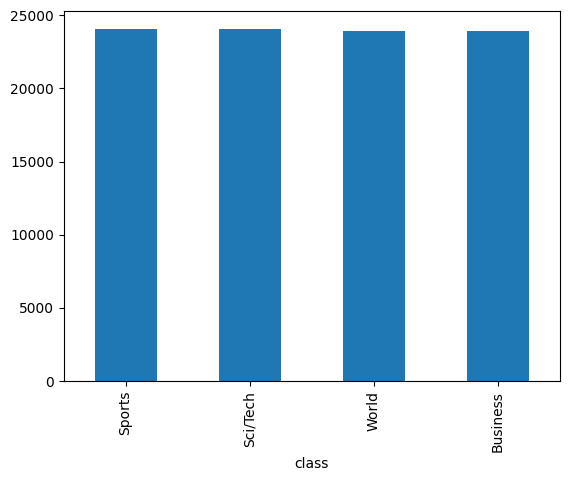

In [18]:
pd.value_counts(train_df['class']).plot.bar()

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [19]:
# Imprimimos el contenido de la columna 'description' para el primer registro en 'train_df'
print(train_df.loc[0, 'description'])
print(train_df.loc[0, 'description'])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [20]:
# Combinamos los textos de 'title' y 'description' en minúsculas y los guardamos en una nueva columna 'text'
train_df['text'] = train_df['title'].str.lower() + " " + train_df['description'].str.lower()

# Reemplazamos las barras invertidas ('\') en 'text' con espacios para limpiar el texto
train_df['text'] = train_df['text'].str.replace('\\', ' ', regex=False)

# Mostramos el DataFrame actualizado
train_df

,class index,class,title,description,text
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...","bbc set for major shake-up, claims newspaper l..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,marsh averts cash crunch embattled insurance b...
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,"jeter, yankees look to take control (ap) ap - ..."
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,flying the sun to safety when the genesis caps...
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,stocks seen flat as nortel and oil weigh new ...
...,...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel...",investors flock to web networking sites intern...
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...,samsung electric quarterly profit up samsung e...
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...,coeur still committed to wheaton deal coeur d ...
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...,clouds on horizon for low-cost airlines new yo...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [21]:
from nltk.tokenize import word_tokenize

# Tokenizamos cada texto en 'train_df' y guardamos los tokens en una columna nueva llamada 'tokens'
train_df['tokens'] = train_df['text'].progress_map(word_tokenize)

# Mostramos el DataFrame actualizado
train_df

  0%|          | 0/96000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...","bbc set for major shake-up, claims newspaper l...","[bbc, set, for, major, shake-up, ,, claims, ne..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,marsh averts cash crunch embattled insurance b...,"[marsh, averts, cash, crunch, embattled, insur..."
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,"jeter, yankees look to take control (ap) ap - ...","[jeter, ,, yankees, look, to, take, control, (..."
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,flying the sun to safety when the genesis caps...,"[flying, the, sun, to, safety, when, the, gene..."
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,stocks seen flat as nortel and oil weigh new ...,"[stocks, seen, flat, as, nortel, and, oil, wei..."
...,...,...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel...",investors flock to web networking sites intern...,"[investors, flock, to, web, networking, sites,..."
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...,samsung electric quarterly profit up samsung e...,"[samsung, electric, quarterly, profit, up, sam..."
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...,coeur still committed to wheaton deal coeur d ...,"[coeur, still, committed, to, wheaton, deal, c..."
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...,clouds on horizon for low-cost airlines new yo...,"[clouds, on, horizon, for, low-cost, airlines,..."


Now we will load the GloVe word embeddings.

In [22]:
from gensim.models import KeyedVectors

# Cargamos los vectores preentrenados de GloVe en un formato compatible con Word2Vec
glove = KeyedVectors.load_word2vec_format("/kaggle/input/glove-300d/glove.6B.300d.txt", no_header=True)

# Mostramos la forma de los vectores (dimensiones del vocabulario y tamaño del vector)
glove.vectors.shape

(400000, 300)

The word embeddings have been pretrained in a different corpus, so it would be a good idea to estimate how good our tokenization matches the GloVe vocabulary.

In [23]:
from collections import Counter

# Función para contar palabras desconocidas (no presentes en el vocabulario)
def count_unknown_words(data, vocabulary):
    counter = Counter()  # Inicializamos un contador
    for row in tqdm(data):  # Recorremos cada fila de datos
        # Contamos cada token que no está en el vocabulario
        counter.update(tok for tok in row if tok not in vocabulary)
    return counter

# Contamos las palabras desconocidas en los tokens del conjunto de entrenamiento
c = count_unknown_words(train_df['tokens'], glove.key_to_index)

# Calculamos el total de tokens en el conjunto de entrenamiento
total_tokens = train_df['tokens'].map(len).sum()

# Calculamos la cantidad de tokens desconocidos
unk_tokens = sum(c.values())

# Calculamos el porcentaje de tokens desconocidos
percent_unk = unk_tokens / total_tokens

# Obtenemos el número de tokens desconocidos distintos
distinct_tokens = len(list(c))

# Mostramos los resultados
print(f'total number of tokens: {total_tokens:,}')
print(f'number of unknown tokens: {unk_tokens:,}')
print(f'number of distinct unknown tokens: {distinct_tokens:,}')
print(f'percentage of unknown tokens: {percent_unk:.2%}')
print('top 50 unknown words:')
for token, n in c.most_common(10):  # Mostramos las 10 palabras desconocidas más comunes
    print(f'\t{n}\t{token}')
``

  0%|          | 0/96000 [00:00<?, ?it/s]

total number of tokens: 4,218,075
number of unknown tokens: 52,882
number of distinct unknown tokens: 20,973
percentage of unkown tokens: 1.25%
top 50 unknown words:
	2379	/b
	1708	href=
	1707	/a
	1461	//www.investor.reuters.com/fullquote.aspx
	1461	target=/stocks/quickinfo/fullquote
	450	/p
	396	newsfactor
	380	cbs.mw
	344	color=
	332	face=


Glove embeddings seem to have a good coverage on this dataset -- only 1.25% of the tokens in the dataset are unknown, i.e., don't appear in the GloVe vocabulary.

Still, we will need a way to handle these unknown tokens.
Our approach will be to add a new embedding to GloVe that will be used to represent them.
This new embedding will be initialized as the average of all the GloVe embeddings.

We will also add another embedding, this one initialized to zeros, that will be used to pad the sequences of tokens so that they all have the same length. This will be useful when we train with mini-batches.

In [24]:
# Definimos tokens especiales para palabras desconocidas y padding
unk_tok = '[UNK]'
pad_tok = '[PAD]'

# Creamos embeddings para estos tokens: promedio de embeddings para [UNK] y ceros para [PAD]
unk_emb = glove.vectors.mean(axis=0)
pad_emb = np.zeros(300)

# Añadimos estos tokens y sus embeddings al modelo GloVe
glove.add_vectors([unk_tok, pad_tok], [unk_emb, pad_emb])

# Obtenemos los IDs de los tokens especiales
unk_id = glove.key_to_index[unk_tok]
pad_id = glove.key_to_index[pad_tok]

# Mostramos los IDs de [UNK] y [PAD]
unk_id, pad_id


(400000, 400001)

In [25]:
from sklearn.model_selection import train_test_split 

# Dividimos 'train_df' en conjuntos de entrenamiento y desarrollo (80% - 20%)
train_df, dev_df = train_test_split(train_df, train_size=0.8)

# Reiniciamos los índices de ambos DataFrames después de la división
train_df.reset_index(inplace=True)
dev_df.reset_index(inplace=True)

We will now add a new column to our dataframe that will contain the padded sequences of token ids.

In [26]:
# Definimos un umbral mínimo de frecuencia para los tokens
threshold = 10

# Contamos la frecuencia de cada token en el conjunto de entrenamiento
tokens = train_df['tokens'].explode().value_counts()

# Creamos un vocabulario con tokens que tienen una frecuencia mayor al umbral
vocabulary = set(tokens[tokens > threshold].index.tolist())

# Mostramos el tamaño del vocabulario resultante
print(f'vocabulary size: {len(vocabulary):,}')


vocabulary size: 15,450


In [27]:

# Obtenemos el número máximo de tokens en un solo registro para determinar la longitud máxima de padding
max_tokens = train_df['tokens'].map(len).max() 

# Función para obtener el ID de un token; usa 'unk_id' si el token no está en el vocabulario
def get_id(tok):
    if tok in vocabulary:  
        return glove.key_to_index.get(tok, unk_id)  
    else:
        return unk_id 

# Función para convertir una lista de tokens en una lista de IDs, agregando padding si es necesario
def token_ids(tokens):
    tok_ids = [get_id(tok) for tok in tokens]  # Convertimos cada token en su ID
    pad_len = max_tokens - len(tok_ids)  # Calculamos el número de tokens de padding a agregar
    return tok_ids + [pad_id] * pad_len  # Devolvemos los IDs con padding al final

# Aplicamos la función 'token_ids' a cada lista de tokens en 'train_df' y guardamos el resultado en 'token ids'
train_df['token ids'] = train_df['tokens'].progress_map(token_ids)  

# Mostramos el DataFrame actualizado
train_df


  0%|          | 0/76800 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,token ids
0,41480,3,Business,Unrest forces oil prices higher,Oil futures have jumped to their highest closi...,unrest forces oil prices higher oil futures ha...,"[unrest, forces, oil, prices, higher, oil, fut...","[4615, 340, 316, 468, 609, 316, 3081, 33, 3450..."
1,112119,4,Sci/Tech,Old News.... REALLY Old News!,"The video archives of Pathe News are online, c...",old news.... really old news! the video archiv...,"[old, news, ..., ., really, old, news, !, the,...","[167, 172, 434, 2, 588, 167, 172, 805, 0, 974,..."
2,75220,2,Sports,Ace in the Hole,General Manager Theo Epstein said the Red Sox ...,ace in the hole general manager theo epstein s...,"[ace, in, the, hole, general, manager, theo, e...","[7588, 6, 0, 2924, 216, 865, 15599, 17434, 16,..."
3,111911,2,Sports,UNDATED: 14 points.,"Tiffany Porter-Talbert scored 24 points, and W...",undated: 14 points. tiffany porter-talbert sco...,"[undated, :, 14, points, ., tiffany, porter-ta...","[5833, 45, 657, 226, 2, 15956, 400000, 878, 79..."
4,80697,2,Sports,"Flatley, Rogers on bench for Australia for rug...","Back from injury, Elton Flatley and Mat Rogers...","flatley, rogers on bench for australia for rug...","[flatley, ,, rogers, on, bench, for, australia...","[400000, 1, 5638, 13, 4530, 10, 603, 10, 2707,..."
...,...,...,...,...,...,...,...,...
76795,110136,2,Sports,Gerrard aiming high,Steven Gerrard insists he #39;ll not accept q...,gerrard aiming high steven gerrard insists he ...,"[gerrard, aiming, high, steven, gerrard, insis...","[15773, 7584, 152, 4411, 15773, 4971, 18, 2749..."
76796,112554,3,Business,Local gamer: Grand Theft Auto #39; steals the ...,Just how excited is Justin Field about the new...,local gamer: grand theft auto #39; steals the ...,"[local, gamer, :, grand, theft, auto, #, 39, ;...","[250, 400000, 45, 1063, 6539, 2612, 2749, 3403..."
76797,116840,3,Business,"Sprint, Nextel Agree To Merge","The deal, valued at \$35 billion, will create ...","sprint, nextel agree to merge the deal, valued...","[sprint, ,, nextel, agree, to, merge, the, dea...","[5514, 1, 17774, 2137, 4, 9194, 0, 435, 1, 595..."
76798,34067,3,Business,Export Cut to China Seen as Clever Strategy on...,"Yukos, the Russian oil giant, is playing a wea...",export cut to china seen as clever strategy on...,"[export, cut, to, china, seen, as, clever, str...","[2467, 611, 4, 132, 541, 19, 11114, 1747, 13, ..."


In [28]:
# Obtenemos el número máximo de tokens en un solo registro para determinar la longitud máxima de padding
max_tokens = train_df['tokens'].map(len).max() 

# Función para obtener el ID de un token; usa 'unk_id' si el token no está en el vocabulario
def get_id(tok):
    if tok in vocabulary:  
        return glove.key_to_index.get(tok, unk_id)  
    else:
        return unk_id 

# Función para convertir una lista de tokens en una lista de IDs, agregando padding si es necesario
def token_ids(tokens):
    tok_ids = [get_id(tok) for tok in tokens]  # Convertimos cada token en su ID
    pad_len = max_tokens - len(tok_ids)  # Calculamos el número de tokens de padding a agregar
    return tok_ids + [pad_id] * pad_len  # Devolvemos los IDs con padding al final

# Aplicamos la función 'token_ids' a cada lista de tokens en 'train_df' y guardamos el resultado en 'token ids'
train_df['token ids'] = train_df['tokens'].progress_map(token_ids)  

# Mostramos el DataFrame actualizado
train_df

  0%|          | 0/19200 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,token ids
0,96457,1,World,House G.O.P. Leader Hails Ethics Panel's Rebuk...,Tom DeLay of Texas claimed vindication today a...,house g.o.p. leader hails ethics panel's rebuk...,"[house, g.o.p, ., leader, hails, ethics, panel...","[166, 400000, 2, 329, 15244, 5321, 1908, 9, 19..."
1,65284,2,Sports,Pittsburgh Steelers Notes,Bill Cowher is no longer 0-for-Texas. He beat ...,pittsburgh steelers notes bill cowher is no lo...,"[pittsburgh, steelers, notes, bill, cowher, is...","[3576, 9841, 2142, 480, 400000, 14, 84, 1078, ..."
2,48958,1,World,"US, Iraq control Samarra","SAMARRA, Iraq - US and Iraqi forces in Samarra...","us, iraq control samarra samarra, iraq - us an...","[us, ,, iraq, control, samarra, samarra, ,, ir...","[95, 1, 233, 424, 19877, 19877, 1, 233, 11, 95..."
3,78606,4,Sci/Tech,Novel Approach Targets Alzheimer #39;s Develop...,A new technique may someday be able to stop Al...,novel approach targets alzheimer #39;s develop...,"[novel, approach, targets, alzheimer, #, 39, ;...","[1999, 1587, 2666, 11533, 2749, 3403, 89, 1534..."
4,68705,1,World,EU #39;s Prodi ready to stay on if new Brussel...,European Commission head Romano Prodi would be...,eu #39;s prodi ready to stay on if new brussel...,"[eu, #, 39, ;, s, prodi, ready, to, stay, on, ...","[644, 2749, 3403, 89, 1534, 400000, 1188, 4, 1..."
...,...,...,...,...,...,...,...,...
19195,105060,4,Sci/Tech,Sun buys IT services company to help HP/IBM fight,Sun Microsystems is buying IT services company...,sun buys it services company to help hp/ibm fi...,"[sun, buys, it, services, company, to, help, h...","[1662, 9911, 20, 522, 128, 4, 275, 400000, 838..."
19196,93591,2,Sports,Raps down and out in LA,The Raptors have to be reminded sometimes that...,raps down and out in la the raptors have to be...,"[raps, down, and, out, in, la, the, raptors, h...","[36092, 135, 5, 66, 6, 1047, 0, 15873, 33, 4, ..."
19197,97615,2,Sports,South Africa in strong position Kanpur Test,KANPUR: Andrew Halls unbeaten knock of 78 help...,south africa in strong position kanpur test ka...,"[south, africa, in, strong, position, kanpur, ...","[139, 637, 6, 562, 704, 42148, 728, 42148, 45,..."
19198,11883,3,Business,Oil Rebounds After Iraq Pipeline Attack,LONDON (Reuters) - Oil prices rose on Friday ...,oil rebounds after iraq pipeline attack londo...,"[oil, rebounds, after, iraq, pipeline, attack,...","[316, 4697, 49, 233, 4523, 436, 516, 23, 10851..."


Now we will get a numpy 2-dimensional array corresponding to the token ids,
and a 1-dimensional array with the gold classes. Note that the classes are one-based (i.e., they start at one),
but we need them to be zero-based, so we need to subtract one from this array.

In [29]:
from torch.utils.data import Dataset

# Definimos una clase personalizada para el dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        # Inicializamos las características (x) y las etiquetas (y)
        self.x = x
        self.y = y
        
    def __len__(self):
        # Devuelve la cantidad de ejemplos en el dataset
        return len(self.y)
    
    def __getitem__(self, index):
        # Obtiene el ejemplo y la etiqueta en el índice especificado
        x = torch.tensor(self.x[index])
        y = torch.tensor(self.y[index])
        return x, y

Next, we construct our PyTorch model, which is a feed-forward neural network with two layers:

In [30]:
from torch import nn  
import torch.nn.functional as F  

# Definimos una clase de modelo de red neuronal personalizada
class Model(nn.Module): 
    def __init__(self, vectors, pad_id, hidden_dim, output_dim, dropout):
        super().__init__()  

        # Convertimos 'vectors' a tensor si no lo es ya
        if not torch.is_tensor(vectors):
            vectors = torch.tensor(vectors)

        # Guardamos el índice de padding
        self.padding_idx = pad_id
    
        # Creamos una capa de embeddings usando los vectores preentrenados y especificamos el índice de padding
        self.embs = nn.Embedding.from_pretrained(vectors, padding_idx=pad_id)
       
        # Definimos las capas secuenciales del modelo
        self.layers = nn.Sequential(
            nn.Dropout(dropout),  # Capa de dropout para regularización
            nn.Linear(vectors.shape[1], hidden_dim),  # Capa lineal de entrada a capa oculta
            nn.ReLU(),  # Función de activación ReLU
            nn.Dropout(dropout),  # Otra capa de dropout
            nn.Linear(hidden_dim, output_dim),  # Capa lineal de salida
        )
        
    def forward(self, x): 
        # Máscara para identificar tokens que no son padding
        not_padding = torch.isin(x, self.padding_idx, invert=True)
      
        # Calculamos la longitud de secuencia (sin contar padding) para cada entrada
        lengths = torch.count_nonzero(not_padding, axis=1)
        
        # Obtenemos los embeddings para cada token en 'x'
        x = self.embs(x)

        # Calculamos la media de los embeddings (ignorando padding)
        x = x.sum(dim=1) / lengths.unsqueeze(dim=1)

        # Pasamos el resultado por las capas del modelo
        output = self.layers(x)

        return output  

Next, we implement the training procedure. We compute the loss and accuracy on the development partition after each epoch.

In [31]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Parámetros de entrenamiento
lr = 1e-3  # Tasa de aprendizaje
weight_decay = 0  # Decaimiento de pesos
batch_size = 500  # Tamaño de lote
shuffle = True  # Si se debe mezclar el conjunto de datos
n_epochs = 5  # Número de épocas
hidden_dim = 50  # Dimensión de la capa oculta
output_dim = len(labels)  # Número de clases
dropout = 0.1  # Dropout
vectors = glove.vectors  # Vectores de embedding preentrenados

# Inicializamos el modelo y lo movemos al dispositivo (CPU o GPU)
model = Model(vectors, pad_id, hidden_dim, output_dim, dropout).to(device)

# Definimos la función de pérdida y el optimizador
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Creamos los datasets para entrenamiento y desarrollo
train_ds = MyDataset(train_df['token ids'], train_df['class index'] - 1)
dev_ds = MyDataset(dev_df['token ids'], dev_df['class index'] - 1)

# Creamos los dataloaders para entrenamiento y desarrollo
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=shuffle)

# Inicializamos listas para registrar la pérdida y precisión
train_loss = []
train_acc = []
dev_loss = []
dev_acc = []

# Bucle de entrenamiento y evaluación
for epoch in range(n_epochs):
    # Entrenamiento
    losses = []
    gold = []
    pred = []
    model.train()  # Modo entrenamiento
    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        model.zero_grad()  # Reiniciamos gradientes
        X, y_true = X.to(device), y_true.to(device)  # Movemos datos al dispositivo
        y_pred = model(X)  # Predicciones del modelo

        loss = loss_func(y_pred, y_true)  # Calculamos la pérdida
        losses.append(loss.detach().cpu().item())  # Registramos la pérdida
        gold.append(y_true.detach().cpu().numpy())  # Etiquetas verdaderas
        pred.append(np.argmax(y_pred.detach().cpu().numpy(), axis=1))  # Predicciones

        loss.backward()  # Calculamos gradientes
        optimizer.step()  # Actualizamos parámetros
    train_loss.append(np.mean(losses))  # Promedio de pérdida de entrenamiento
    train_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))  # Precisión de entrenamiento
    
    # Evaluación
    model.eval()  # Modo evaluación
    with torch.no_grad():  # Sin cálculo de gradientes
        losses = []
        gold = []
        pred = []
        for X, y_true in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            X, y_true = X.to(device), y_true.to(device)
            y_pred = model(X)
            loss = loss_func(y_pred, y_true)  # Calculamos la pérdida
            losses.append(loss.cpu().item())
            gold.append(y_true.cpu().numpy())
            pred.append(np.argmax(y_pred.cpu().numpy(), axis=1))
        dev_loss.append(np.mean(losses))  # Promedio de pérdida de evaluación
        dev_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))  # Precisión de evaluación

epoch 1 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 5 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

Let's plot the loss and accuracy on dev:

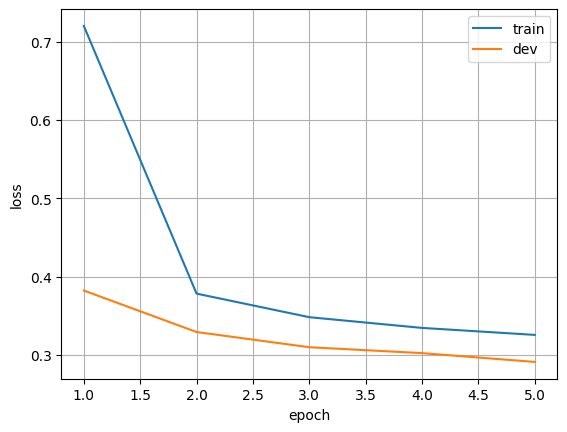

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# Definimos el eje x para representar cada época
x = np.arange(n_epochs) + 1

# Graficamos la pérdida de entrenamiento y desarrollo por cada época
plt.plot(x, train_loss)
plt.plot(x, dev_loss)

# Añadimos leyenda para diferenciar entre las pérdidas de entrenamiento y desarrollo
plt.legend(['train', 'dev'])

# Etiquetas para los ejes
plt.xlabel('epoch')
plt.ylabel('loss')

# Mostramos la cuadrícula en el gráfico
plt.grid(True)

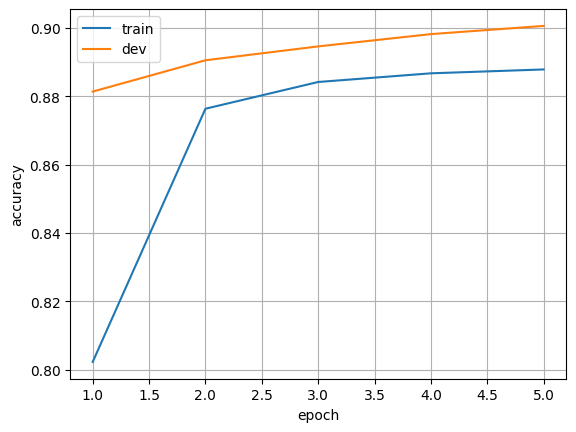

In [33]:
# Graficamos la precisión de entrenamiento y desarrollo por cada época
plt.plot(x, train_acc)
plt.plot(x, dev_acc)

# Añadimos leyenda para diferenciar entre la precisión de entrenamiento y desarrollo
plt.legend(['train', 'dev'])

# Etiquetas para los ejes
plt.xlabel('epoch')
plt.ylabel('accuracy')

# Mostramos la cuadrícula en el gráfico
plt.grid(True)

In [ ]:
from nltk.tokenize import word_tokenize

# Tokenizamos cada texto en 'train_df' y guardamos los tokens en una nueva columna llamada 'tokens'
train_df['tokens'] = train_df['text'].progress_map(word_tokenize)

# Mostramos el DataFrame actualizado
train_df

  0%|          | 0/96000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...","bbc set for major shake-up, claims newspaper l...","[bbc, set, for, major, shake-up, ,, claims, ne..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,marsh averts cash crunch embattled insurance b...,"[marsh, averts, cash, crunch, embattled, insur..."
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,"jeter, yankees look to take control (ap) ap - ...","[jeter, ,, yankees, look, to, take, control, (..."
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,flying the sun to safety when the genesis caps...,"[flying, the, sun, to, safety, when, the, gene..."
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,stocks seen flat as nortel and oil weigh new ...,"[stocks, seen, flat, as, nortel, and, oil, wei..."
...,...,...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel...",investors flock to web networking sites intern...,"[investors, flock, to, web, networking, sites,..."
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...,samsung electric quarterly profit up samsung e...,"[samsung, electric, quarterly, profit, up, sam..."
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...,coeur still committed to wheaton deal coeur d ...,"[coeur, still, committed, to, wheaton, deal, c..."
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...,clouds on horizon for low-cost airlines new yo...,"[clouds, on, horizon, for, low-cost, airlines,..."


Next, we evaluate on the testing partition:

In [34]:
# Cargamos el conjunto de datos de prueba y configuramos los nombres de las columnas
test_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')
test_df.columns = ['class index', 'title', 'description']

# Combinamos 'title' y 'description' en una sola columna 'text' en minúsculas y limpiamos barras invertidas
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower()
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False)

# Tokenizamos el texto en palabras y almacenamos los tokens en una nueva columna 'tokens'
test_df['tokens'] = test_df['text'].progress_map(word_tokenize)

# Obtenemos el número máximo de tokens en el conjunto de desarrollo (dev_df) para el padding
max_tokens = dev_df['tokens'].map(len).max()

# Convertimos los tokens en IDs y aplicamos padding según 'max_tokens', guardando el resultado en 'token ids'
test_df['token ids'] = test_df['tokens'].progress_map(token_ids)


  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [35]:
from sklearn.metrics import classification_report

# Colocamos el modelo en modo de evaluación
model.eval()

# Creamos el dataset y el DataLoader para los datos de prueba
dataset = MyDataset(test_df['token ids'], test_df['class index'] - 1)
data_loader = DataLoader(dataset, batch_size=batch_size)

# Inicializamos una lista para almacenar las predicciones
y_pred = []

# Evaluación sin gradientes
with torch.no_grad():
    for X, _ in tqdm(data_loader):
        X = X.to(device)  # Movemos los datos al dispositivo

        # Obtenemos la predicción de clase más probable para cada ejemplo
        y = torch.argmax(model(X), dim=1)

        # Almacenamos las predicciones
        y_pred.append(y.cpu().numpy())

    # Generamos el reporte de clasificación usando las etiquetas verdaderas y las predicciones
    print(classification_report(dataset.y, np.concatenate(y_pred), target_names=labels))

  0%|          | 0/16 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       World       0.92      0.88      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.85      0.85      0.85      1900
    Sci/Tech       0.86      0.87      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

